# **What is a Generative Adversarial Network (GAN)?**

#### **The Art of Imitation:** GANs are a type of deep learning architecture where two neural networks are locked in an elaborate game of cat-and-mouse.  Think of them as a master art forger and an expert art critic:
   **The Generator:** The 'art forger' responsible for creating realistic fakes that could pass as authentic pieces (e.g., images, music, text etc.).
     
   **The Discriminator:**  The 'art critic'  trained to tell the difference between a genuine masterpiece and the generator's forgeries.

#### **A Competitive Game:**  Both networks get better through this competition.  The generator keeps refining its fakes to fool the discriminator, and the discriminator gets better at spotting the subtle flaws in those fakes. Over time, the generator gets so good that its creations become indistinguishable from real data.

## Basic Concepts

1. **Unsupervised Learning:** GANs don't need labeled data. They learn from a dataset of examples (e.g., a collection of real photographs), extracting the patterns and underlying structure without explicit labels like "dog" or "cat."

2. **Generator Network:**
   * Takes random noise as input.
   * Tries to transform that noise into data that resembles the real examples it has seen.
   * Its goal is to make the discriminator believe its outputs are real.

3. **Discriminator Network:**
   * Takes as input both real data samples and the generator's outputs.
   * Tries to classify whether an input is "real" (from the training dataset) or "fake" (created by the generator).
   * Gives feedback to the generator to help it improve its fakes.

4. **Adversarial Training:**
   * The generator and discriminator are trained simultaneously.
   * The generator improves by making the discriminator's job harder.
   * The discriminator improves by becoming a better judge of authenticity.
   * It's this constant push-and-pull that makes GANs so powerful.

**Why use GANs?**

* **Generating New Data:** Create realistic images, music, videos, or other data forms that weren't in your original dataset.
* **Data Augmentation:** Increase the size and diversity of a dataset, useful in areas where real data is scarce.
* **Image-to-Image Translation:** Change images from one style to another (e.g., turning sketches into photos).
* **Super Resolution:** Enhancing image or video quality.

**Ready to Build?**

Building a GAN involves:

* **Choosing Your Domain:**  Images, text, audio, etc.
* **Data Preparation:**  Gathering or creating a suitable dataset.
* **Network Architecture:**  Designing your generator and discriminator networks (often using convolutional neural networks for images).
* **Training Setup:**  Defining the loss functions that guide the networks and selecting an optimization algorithm. 
* **Implementation:**  Coding your GAN using a deep learning framework like TensorFlow or PyTorch.




In [28]:
import tensorflow as tf
import tensorflow_datasets as tfds
import random
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from keras.regularizers import l1
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from sklearn.utils import class_weight
from tensorflow.keras import backend as K 
from keras.preprocessing.sequence import pad_sequences 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA


import re

seed = 42
random.seed(seed)

In [29]:
#Checks if GPU is being used
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("Using GPU:", torch.cuda.get_device_name(0)) 
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("GPU not available, using CPU.")

#Using GPU: NVIDIA GeForce GTX 1660 SUPER - Successful
#NOTE: This took some time to set up by installing and pathing the cuda toolkit v.12.4 and the right supplemental packages. This drastically improved
#training time

Using GPU: NVIDIA GeForce GTX 1660 SUPER


In [30]:
#import Dataset
fashion_mnist = tf.keras.datasets.fashion_mnist

#split dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [31]:
#Preprocessing:

# Data Conversion and Normalization
train_images = tf.cast(train_images, tf.float32)  # Convert to float32 / this type is needed, MNIST is unit8 type
train_images /= 255.0  # Normalize to [0, 1] range

# Do the same for the test dataset if needed:
test_images = tf.cast(test_images, tf.float32)
test_images /= 255.0  

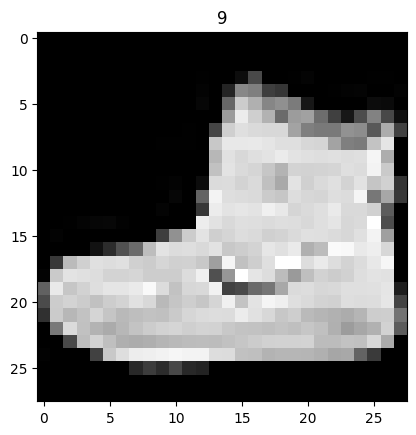

In [39]:
# Let's look at the first image and its label
plt.imshow(train_images[0], cmap='gray')
plt.title(train_labels[0])
plt.show()

In [33]:
codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                           activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                           activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [34]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Since the training loop is unusual, we cannot use the regular fit() method. Instead, we will write a custom training loop. For this, we first need to create a Dataset to iterate through the images:

In [41]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        for X_batch in dataset:

            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, tf.expand_dims(X_batch, axis=-1)], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)

train_gan(gan, dataset, batch_size, codings_size, n_epochs=20)

ValueError: You must call `compile()` before using the model.

In [35]:
codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
